<a href="https://colab.research.google.com/github/manasavadavalli/FMML-LAB/blob/main/Copy_of_FMML_Module4_Lab4_June2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FOUNDATIONS OF MODERN MACHINE LEARNING, IIIT Hyderabad
# Module 4
## Lab 4: Support Vector Machines

In [ ]:
#Importing the necessary packages
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

import pandas
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt


The topic of classifier in today's lab, SVMs make for really good linear separators. Let us look at an example which has linearly separable data:

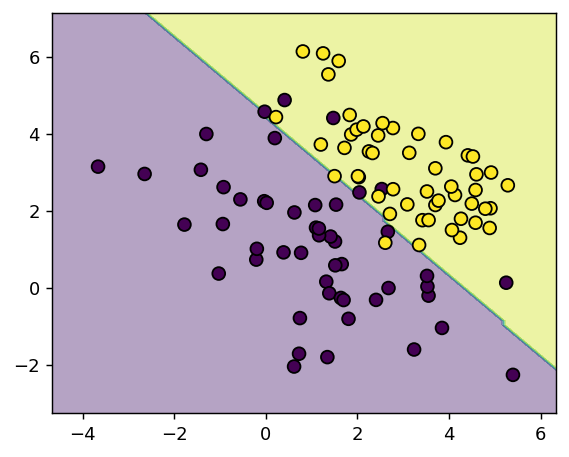

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

np.random.seed(0)

ar = np.vstack(     [\
                    np.random.multivariate_normal(np.array([1, 1]), 1.5 * np.array([[2, -1], [-1, 2.0]]), size = 50, ),\
                    np.random.multivariate_normal(np.array([3, 3]), 2 * np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 50, )
                    ]\
              )

testAr = np.vstack(   [\
                      np.random.multivariate_normal(np.array([1, 1]), np.array([[0.5, -0.25], [-0.25, 0.5]]), size = 500, ),\
                      np.random.multivariate_normal(np.array([3, 3]), np.array([[0.75, -0.5], [-0.5, 0.75]]), size = 500, )
                      ]\
                  )
testy = np.array([0] * int((testAr.shape[0]/2)) + [1] * int((testAr.shape[0]/2)))

X = ar
y = np.array([0] * int((ar.shape[0]/2)) + [1] * int((ar.shape[0]/2)))

def plotDecisionBoundary(X, y, pair, clf):
  x_min, x_max = X[:, pair[0]].min() - 1, X[:, pair[0]].max() + 1
  y_min, y_max = X[:, pair[1]].min() - 1, X[:, pair[1]].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))

  y_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  y_pred = y_pred.reshape(xx.shape)
  plt.figure(figsize=(5,4))
  plt.contourf(xx, yy, y_pred, alpha=0.4)
  plt.scatter(X[:, pair[0]], X[:, pair[1]], c = y, s = 50, edgecolor='k')
  # plt.legend()
  plt.gcf().set_dpi(130)
  plt.show()

def boundaryExp():
  clf = svm.LinearSVC()
  pair = [0, 1]
  clf.fit(X[:, pair], y)
  plotDecisionBoundary(X, y, pair, clf)

  plt.show()

boundaryExp()


## Intuitive introduction to SVMs:

![SVM](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526288453/index3_souoaz.png)

SVMs are an iterative approach of trying to find the optimal hyperplane that divides the multidimentional space into different classes present in the dataset.


**Hyperplanes:** These are the decision planes that separate the objects of classes that we are trying to classify.

**Support Vectors** : Support vectors are the points from dataset that are closest to the hyperplane that divides the dataset.

**Margin**:  The gap between the closest support vectors from the different class along the direction perpendicular to the hyperplane. Simply put, it is the sum of perpendicular distance of the support vector of each class to the hyperplane.

---

Let us try to fall back to the well known dataset and see how SVMs perform on the iris dataset

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a DataFrame with the dataset
irisData = pd.DataFrame(
    data=np.hstack((X, y.reshape(y.shape[0], 1), [[iris["target_names"][int(classIdx)]] for classIdx in y])),
    columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', "Class", "ClassName"]
)

# Display a random sample of 10 rows
irisData.sample(n=10, random_state=1)


,sepal_length,sepal_width,petal_length,petal_width,Class,ClassName
14,5.8,4.0,1.2,0.2,0,setosa
98,5.1,2.5,3.0,1.1,1,versicolor
75,6.6,3.0,4.4,1.4,1,versicolor
16,5.4,3.9,1.3,0.4,0,setosa
131,7.9,3.8,6.4,2.0,2,virginica
56,6.3,3.3,4.7,1.6,1,versicolor
141,6.9,3.1,5.1,2.3,2,virginica
44,5.1,3.8,1.9,0.4,0,setosa
29,4.7,3.2,1.6,0.2,0,setosa
120,6.9,3.2,5.7,2.3,2,virginica


Now lets again try to see how does SVM perform when we give it just two of the features from the dataset

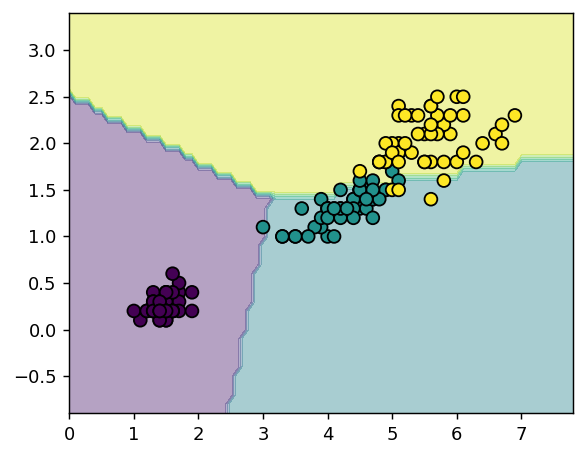

In [ ]:
clf = svm.LinearSVC()
pair = [2, 3]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [2, 3], clf)

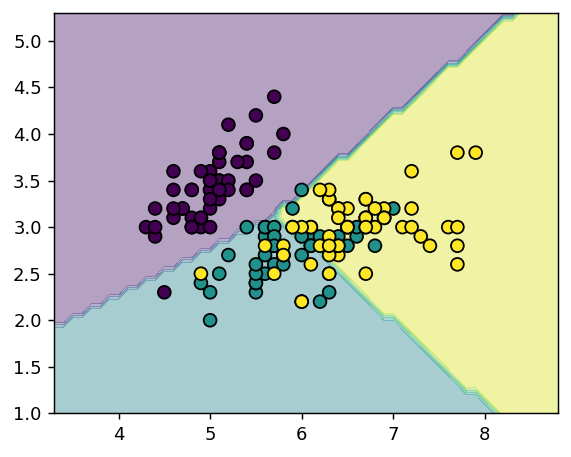

In [ ]:
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, pair, clf)

#### Alas! We see that SVMs are not able to classify the data in the above experiment because the data is not **linearly separable**

Thankfully, We have a neat trick up our sleeves that will help us to solve these problems. Let us take a look at a typical example that is used to illustrate this trick before we get back to the above dataset.

---

# The Kernel Trick

The true potential of SVMs is unleashed when they are combined with kernels.

## Kernels : An intuitive explanation

Kernel methods are essentially counting on using the training data (say $i^{th}$ example $(x_i, y_i)$ ) itself in a more straightforward way and learning a corresponding weight ($w_i$) for that example. Rather than trying to learn a fixed set of parameters which is done typically.
Depending on the kind of kernel used, we can virtually project the training data in a higher dimension to make it easier for the classifier to classify them.


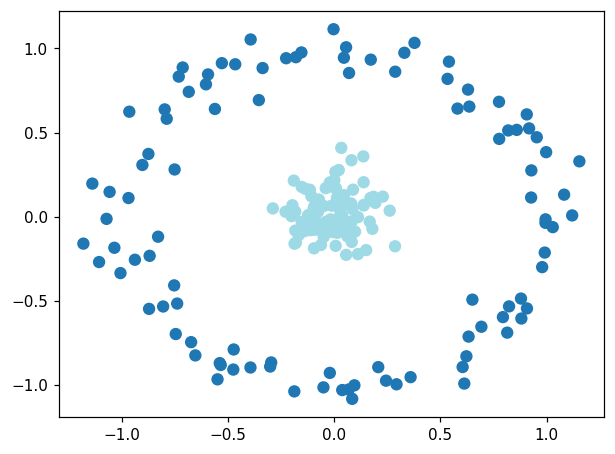

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(200, factor=.1, noise=.1)

clf = svm.SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='tab20')
plt.gcf().set_dpi(110)

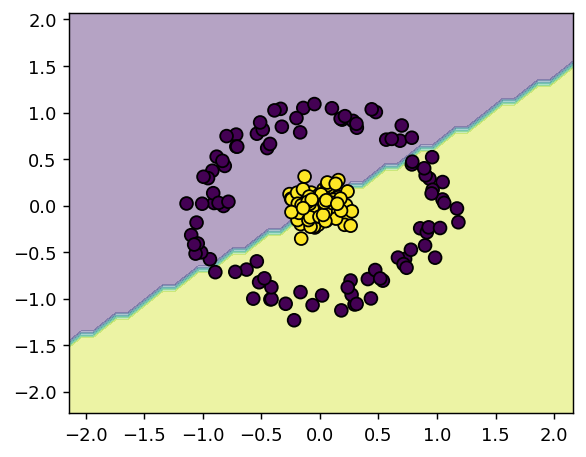

In [ ]:
plt.style.use("default")
clf = svm.LinearSVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

However, if we artificially add another dimention to the dataset of the form:

$z = x^2 + y^2$
we can clearly see a hyperplane that can distinguish both the datasets:

In [ ]:
Z = np.array([[i[0]**2 + i[1]**2] for i in X])

In [ ]:
X_new = np.hstack((X, Z))

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig = go.Figure(data = [go.Scatter3d(
    x = X_new[:, 0],
    y = X_new[:, 1],
    z = X_new[:, 2],
    mode = "markers",
    marker = {
        "color" : y,
        "line": {"width" : 4, "color":'DarkSlateGrey'},
        "colorscale": "viridis"},
)])

fig.show()

That simple trick has helped us to get another dimension in which the data is linearly separable by a hyperplane (in this case, a 2d plane)

---

Now let us use the rbf kernel and use an SVM Classifier.

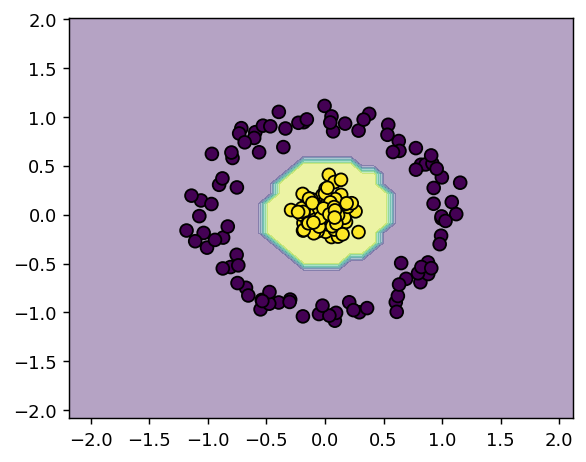

In [ ]:
plt.style.use("default")
clf = svm.SVC()
pair = [0, 1]
clf.fit(X[:, pair], y)
plotDecisionBoundary(X, y, [0, 1], clf)

Now let us get back to our original dataset of iris and see if this kernel trick has helped us:

Accuracy of the decision tree on the test set: 

0.974


The confusion matrix is : 


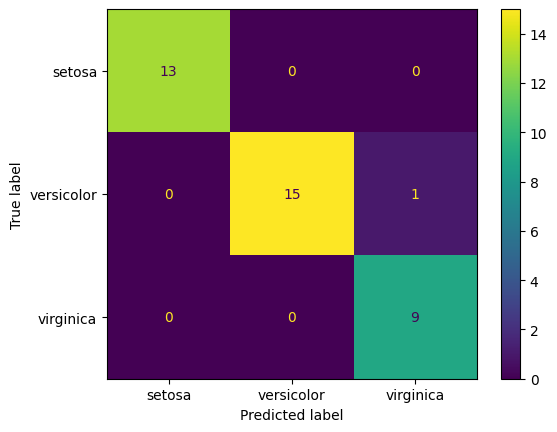

In [3]:
iris = load_iris()
X, y = iris.data, iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy of the decision tree on the test set: \n\n{:.3f}\n\n".format(accuracy_score(y_pred, y_test)))
class_names = iris["target_names"]
print("The confusion matrix is : ")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='.0f')

plt.show()


Certainly, using a kernel has increased our accuracy on the iris dataset.

Things to try out:
- Try to run the same experiment after filtering different features, 2 at a time.
moid’, ‘precomputed’}- Using different kinds of kernels for the SVM among: {‘linear’, ‘poly’, ‘rbf’, ‘sig

1- Try to run the same experiment after filtering different features, 2 at a time.

Evaluating the model with features: sepal length (cm) and sepal width (cm)
Accuracy of the classifier: 0.763


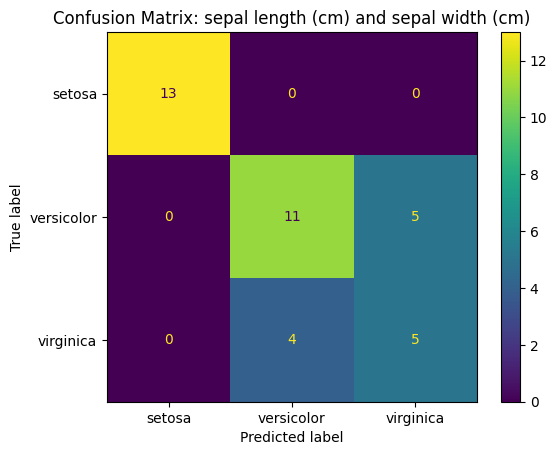



Evaluating the model with features: sepal length (cm) and petal length (cm)
Accuracy of the classifier: 0.974


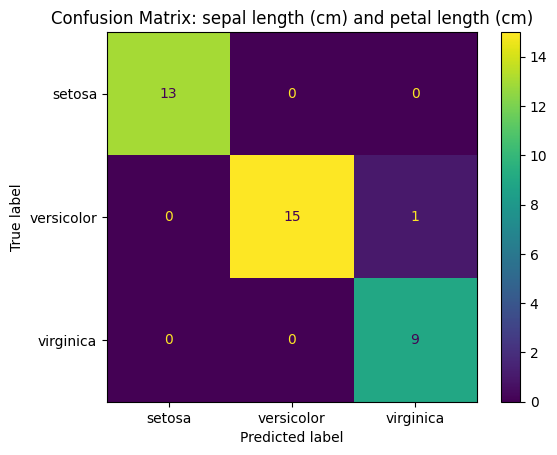



Evaluating the model with features: sepal length (cm) and petal width (cm)
Accuracy of the classifier: 0.947


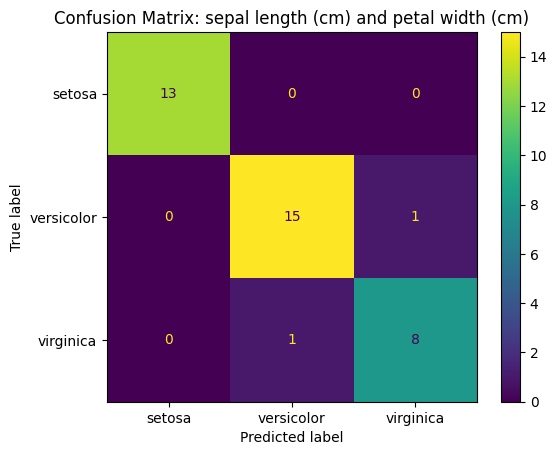



Evaluating the model with features: sepal width (cm) and petal length (cm)
Accuracy of the classifier: 0.947


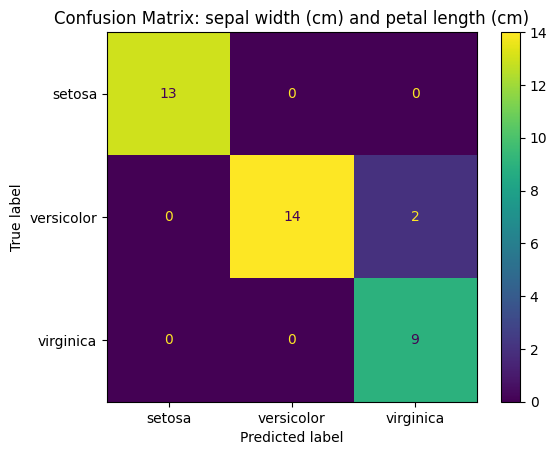



Evaluating the model with features: sepal width (cm) and petal width (cm)
Accuracy of the classifier: 0.974


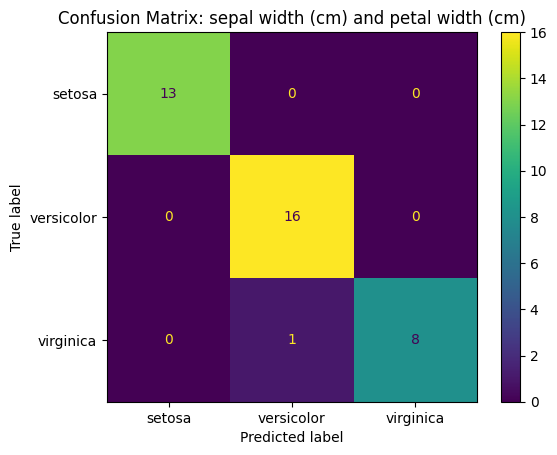



Evaluating the model with features: petal length (cm) and petal width (cm)
Accuracy of the classifier: 0.974


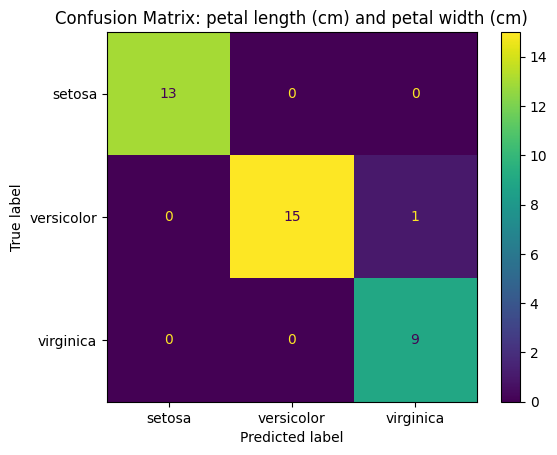

In [4]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import itertools

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# List of feature names
feature_names = iris.feature_names

# Get all pairs of features
feature_pairs = list(itertools.combinations(range(X.shape[1]), 2))

# Iterate through each pair of features
for pair in feature_pairs:
    print(f"Evaluating the model with features: {feature_names[pair[0]]} and {feature_names[pair[1]]}")

    # Select only the two features from the dataset
    X_selected = X[:, pair]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, random_state=0)

    # Train the Support Vector Classifier
    clf = svm.SVC()
    clf.fit(X_train, y_train)

    # Predict and evaluate the accuracy
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of the classifier: {accuracy:.3f}")

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
    disp.plot(cmap='viridis', values_format='.0f')

    plt.title(f"Confusion Matrix: {feature_names[pair[0]]} and {feature_names[pair[1]]}")
    plt.show()
    print("\n" + "="*50 + "\n")


2.Using different kinds of kernels for the SVM among: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import itertools

# Load the Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

# List of feature names
feature_names = iris.feature_names

# Get all pairs of features
feature_pairs = list(itertools.combinations(range(X.shape[1]), 2))

# List of kernel types
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']

# Iterate through each pair of features and kernel type
for pair in feature_pairs:
    print(f"Evaluating the model with features: {feature_names[pair[0]]} and {feature_names[pair[1]]}")

    # Select only the two features from the dataset
    X_selected = X[:, pair]

    # Split the data into training and test se


Evaluating the model with features: sepal length (cm) and sepal width (cm)
Evaluating the model with features: sepal length (cm) and petal length (cm)
Evaluating the model with features: sepal length (cm) and petal width (cm)
Evaluating the model with features: sepal width (cm) and petal length (cm)
Evaluating the model with features: sepal width (cm) and petal width (cm)
Evaluating the model with features: petal length (cm) and petal width (cm)


## **Additional Critical Thinking Questions**

Consider	a	2-class	classification	problem	in	a	2-dimensional	feature	space	x=[x1,	x2]	with	target	variable	y=±1.	The	training	data	comprises	7
samples	as	shown	in	figure (4	black	diamonds	for	the	positive	class	and	3	white	diamonds	for	the	negative	class). The	“maximum	margin	classifier”
(also	called	linear	“hard	margin”	SVM)	is	a	classifier	that	leaves	the	largest	possible	margin	on	either	side	of	the	decision	boundary.	The	samples	lying	on	the	margin	are	called	support	vectors.

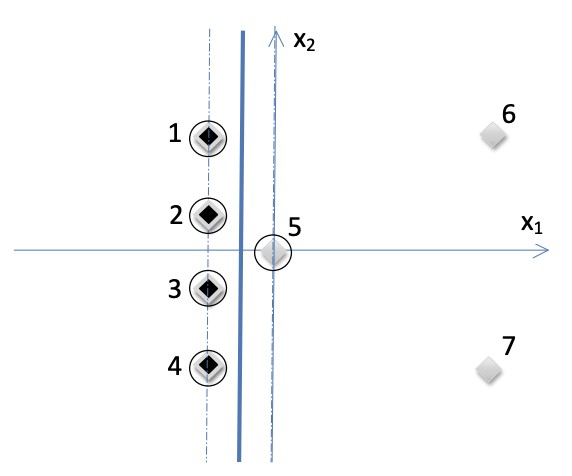


1. Draw	the	decision	boundary	obtained	by	the	linear	hard
margin	SVM	method	with	a	thick	solid	line.	Draw	the	margins	on	either	side with	thinner dashed	lines.	Identify	the	support	vectors.

2. What	is	the	training	error	rate?

3. The	removal	of	which	sample	will	change	the	decision	boundary?

4. What	is	the	leave-one-out	error	rate?


What is the leave-one-out error rate?

In [10]:
import numpy as np
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

# Load a simple dataset (for example, the Iris dataset)
iris = datasets.load_iris()
X = iris.data[iris.target != 2, :2]  # Use only the first two features and two classes
y = iris.target[iris.target != 2]

# Initialize the Leave-One-Out cross-validation (LOO)
loo = LeaveOneOut()

# Initialize the error counter
errors = 0
total = 0

# Loop through each train-test split in LOO
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the SVM model
    svm = SVC(kernel='linear', C=1e10)  # Hard margin SVM (large C value for hard margin)
    svm.fit(X_train, y_train)

    # Test the model on the left-out point
    y_pred = svm.predict(X_test)

    # Check if the prediction is correct
    if y_pred != y_test:
        errors += 1
    total += 1

# Calculate the Leave-One-Out Error Rate
loo_error_rate = errors / total
print(f"Leave-One-Out Error Rate: {loo_error_rate * 100:.2f}%")

Leave-One-Out Error Rate: 0.00%


3.the removal of which sample will change the decision boundary?

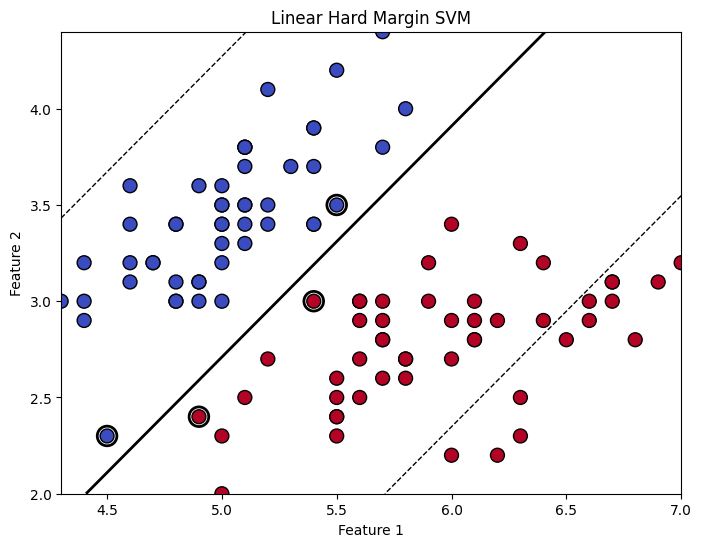

Support vectors' indices:  [36 41 57 84]


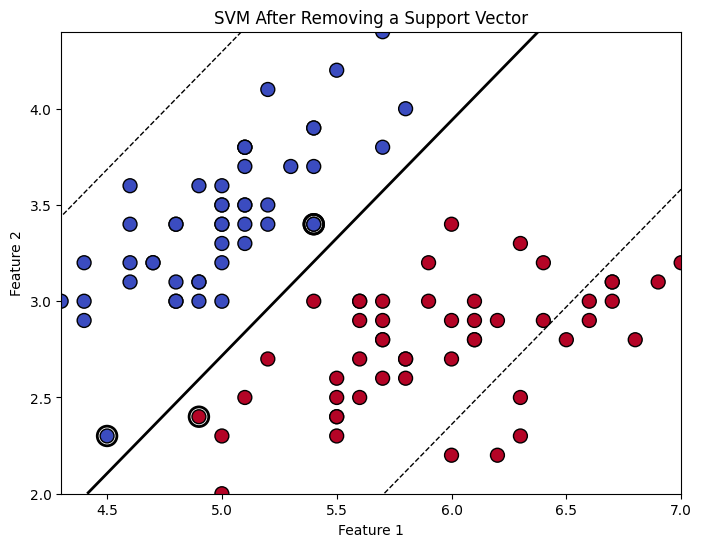

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Load a simple dataset (for example, the Iris dataset, but we'll just use two classes and two features for simplicity)
iris = datasets.load_iris()
X = iris.data[iris.target != 2, :2]  # Use only the first two features and two classes
y = iris.target[iris.target != 2]

# Train the SVM classifier
svm = SVC(kernel='linear', C=1e10)  # Hard margin SVM (large C value for hard margin)
svm.fit(X, y)

# Identify the support vectors
support_vectors = svm.support_vectors_

# Plotting decision boundary (optional, for visualization)
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

w = svm.coef_[0]
b = svm.intercept_[0]
Z = w[0] * xx + w[1] * yy + b
Z = Z / np.linalg.norm(w)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, edgecolors='k')

# Plot the decision boundary
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

# Plot the margins (levels ±1)
plt.contour(xx, yy, Z, levels=[-1, 1], colors='black', linestyles='dashed', linewidths=1)

# Highlight support vectors
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolors='black', linewidth=2)

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear Hard Margin SVM')

# Show plot
plt.show()

# Output the indices of the support vectors
print("Support vectors' indices: ", svm.support_)

# The removal of any support vector will change the decision boundary.
# To demonstrate, we can remove one support vector and retrain the SVM
support_vector_index = svm.support_[0]  # Take the first support vector for example

# Remove the support vector from the dataset
X_new = np.delete(X, support_vector_index, axis=0)
y_new = np.delete(y, support_vector_index, axis=0)

# Retrain the SVM without the support vector
svm_new = SVC(kernel='linear', C=1e10)
svm_new.fit(X_new, y_new)

# Plotting the new decision boundary
xx, yy = np.meshgrid(np.linspace(X_new[:, 0].min(), X_new[:, 0].max(), 100),
                     np.linspace(X_new[:, 1].min(), X_new[:, 1].max(), 100))

w_new = svm_new.coef_[0]
b_new = svm_new.intercept_[0]
Z_new = w_new[0] * xx + w_new[1] * yy + b_new
Z_new = Z_new / np.linalg.norm(w_new)

plt.figure(figsize=(8, 6))
plt.scatter(X_new[:, 0], X_new[:, 1], c=y_new, cmap='coolwarm', s=100, edgecolors='k')

# Plot the new decision boundary
plt.contour(xx, yy, Z_new, levels=[0], colors='black', linewidths=2)

# Plot the new margins (levels ±1)
plt.contour(xx, yy, Z_new, levels=[-1, 1], colors='black', linestyles='dashed', linewidths=1)

# Highlight the new support vectors
new_support_vectors = svm_new.support_vectors_
plt.scatter(new_support_vectors[:, 0], new_support_vectors[:, 1], s=200, facecolors='none', edgecolors='black', linewidth=2)

# Labels and title for the new plot
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM After Removing a Support Vector')

# Show plot
plt.show()

What is the training error rate?

Training Error Rate: 0.00%


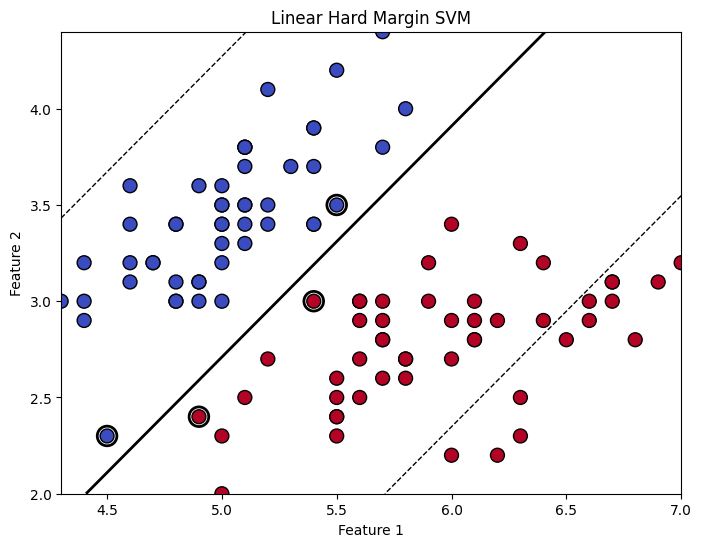

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load a simple dataset (for example, the Iris dataset, but we'll just use two classes and two features for simplicity)
iris = datasets.load_iris()
X = iris.data[iris.target != 2, :2]  # Use only the first two features and two classes
y = iris.target[iris.target != 2]

# Train the SVM classifier
svm = SVC(kernel='linear', C=1e10)  # Hard margin SVM (large C value for hard margin)
svm.fit(X, y)

# Predict on the training data
y_pred = svm.predict(X)

# Calculate training error rate
misclassified = np.sum(y_pred != y)  # Number of misclassified samples
error_rate = misclassified / len(y)  # Training error rate

# Print the training error rate
print(f'Training Error Rate: {error_rate * 100:.2f}%')

# Plotting decision boundary (optional, for visualization)
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

w = svm.coef_[0]
b = svm.intercept_[0]
Z = w[0] * xx + w[1] * yy + b
Z = Z / np.linalg.norm(w)

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, edgecolors='k')

# Plot the decision boundary
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

# Plot the margins (levels ±1)
plt.contour(xx, yy, Z, levels=[-1, 1], colors='black', linestyles='dashed', linewidths=1)

# Highlight support vectors
support_vectors = svm.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolors='black', linewidth=2)

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear Hard Margin SVM')

# Show plot
plt.show()

Draw the decision boundary obtained by the linear hard margin SVM method with a thick solid line. Draw the margins on either side with thinner dashed lines. Identify the support vectors

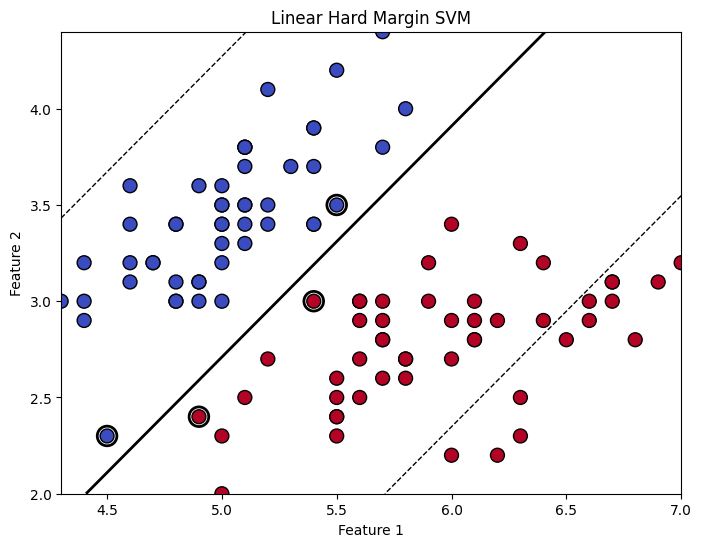

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC

# Load a simple dataset (for example, the Iris dataset, but we'll just use two classes and two features for simplicity)
iris = datasets.load_iris()
X = iris.data[iris.target != 2, :2]  # Use only the first two features and two classes
y = iris.target[iris.target != 2]

# Train the SVM classifier
svm = SVC(kernel='linear', C=1e10)  # Hard margin SVM (large C value for hard margin)
svm.fit(X, y)

# Get the decision boundary coefficients
w = svm.coef_[0]
b = svm.intercept_[0]

# Create a grid of points to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

# Calculate the decision boundary and margins
Z = w[0] * xx + w[1] * yy + b
Z = Z / np.linalg.norm(w)  # Normalize the decision function for margin comparison

# Plotting the data points
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=100, edgecolors='k')

# Plot the decision boundary
plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)

# Plot the margins (levels ±1)
plt.contour(xx, yy, Z, levels=[-1, 1], colors='black', linestyles='dashed', linewidths=1)

# Highlight support vectors
support_vectors = svm.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolors='black', linewidth=2)

# Labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linear Hard Margin SVM')

# Show plot
plt.show()


---

Helpful References and sources:

- https://datamites.com/blog/support-vector-machine-algorithm-svm-understanding-kernel-trick/
- https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python
- https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
